In [1]:
import IPython
import sklearn
import numpy as np
import kmapper as km
import pandas as pd
import seaborn as sns
from umap import UMAP

from sklearn.manifold import t_sne, isomap

from sklearn import datasets
from sklearn.cluster import DBSCAN

from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [2]:
import cx_Oracle

# oracle
oracle_user = "ro_user"
oracle_pass = "ro_user"
oracle_scheme = "aml_evraz"
oracle_host = "192.168.101.13/rnd"
oracle_connection = cx_Oracle.connect(oracle_user, oracle_pass, oracle_host, encoding = "UTF-8", nencoding = "UTF-8")
oracle_cursor = oracle_connection.cursor()

In [3]:
table_names = {
    'off_operations': 'TB_OFFLINEOPERATIONS',
    'off_members': 'MV_OFF_MEMBERS',
    'susp_operations': 'TB_SUSPICIOUSOPERATIONS',
    'susp_mem': 'TB_SUSPICIOUSMEMBERS',
    'susp_acc': 'TB_SUSP_MEMBERS'
}

In [4]:
def df_categorical_variables_stat(df, max_cardinality=200):
    for colname in df.columns:
        print('next_column: {}'.format(colname))
        uniq_vals = df[colname].unique()
        nunique = len(uniq_vals)
        print("# of uniqs: {}".format(nunique))
        if nunique < max_cardinality:
            print('Viable Categorical. Value counts:')
            print(df[colname].value_counts(dropna=False))
        else:
            print('High cardinality/Non categorical')
        print((('-' * 80) + '\n')*3)

In [5]:
#query = "select * from "+oracle_scheme+".tb_ipdl"
def table_len(cursor, scheme, table_name):
    len_query = "select count(1) from {scheme}.{table_name}".format(scheme=scheme, table_name=table_name)
    return cursor.execute(len_query)

In [6]:
for table_name in table_names.values():
    for len_result in table_len(oracle_cursor, oracle_scheme, table_name):
        print("{table_name} has {num_rows} rows".format(table_name=table_name, num_rows=len_result[0]))

MV_OFF_MEMBERS has 11518649 rows
TB_OFFLINEOPERATIONS has 8222263 rows
TB_SUSP_MEMBERS has 913563 rows
TB_SUSPICIOUSOPERATIONS has 401557 rows
TB_SUSPICIOUSMEMBERS has 1864282 rows


In [40]:
columns_to_select_by = [
    'ID',
    'P_ISSUEDBID',
    'P_ORDERNUMBER',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_OPERATIONDATETIME',
    'P_BASEAMOUNT',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCDATE',
    'P_DOCCATEGORY',
    'P_OPERATIONSTATUS',
    'P_OPERATIONREASON',
    'P_CHECKED',
    'P_TOEXTRACTBOOL',
    'P_DOCTYPE',
    'P_DOCSUSPIC',
    'P_PROPERTY',
    'P_PROPERTYNUMBER',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_ORIG_OPER_NUMBER',
]

In [41]:
df_offline_ops = pd.read_sql_query("select * from {scheme}.{table_name} where ROWNUM <= 1000000"\
                                   .format(scheme=oracle_scheme, table_name=table_names['off_operations']),
                                  con=oracle_connection)

In [42]:
df_offline_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_ORDERNUMBER', 'P_BRANCH',
       'P_CURRENCYCODE', 'P_OPERATIONDATETIME', 'P_BASEAMOUNT',
       'P_CURRENCYAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCDATE',
       'P_DOCCATEGORY', 'P_OPERATIONSTATUS', 'P_OPERATIONREASON', 'P_CHECKED',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'P_DATE_UPDATE', 'CHANGEDATE',
       'P_DOCTYPE', 'P_DOCSUSPIC', 'P_PROPERTY', 'P_PROPERTYNUMBER',
       'P_KFM_OPER_REASON', 'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER',
       'P_HISTORY', 'P_WAS_SEND', 'P_SDP', 'RISK_CHECKED',
       'P_INNER_SUSP_CHECK', 'P_OPERATIONDATE'],
      dtype='object')

In [43]:
df_categorical_variables_stat(df_offline_ops)

next_column: ID
# of uniqs: 1000000
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_ISSUEDBID
# of uniqs: 5
Viable Categorical. Value counts:
5    651654
3    253316
1     86788
4      5762
2      2480
Name: P_ISSUEDBID, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BANKOPERATIONID
# of uniqs: 1000000
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------

# of uniqs: 1
Viable Categorical. Value counts:
NaN    1000000
Name: P_DOCSUSPIC, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_PROPERTY
# of uniqs: 4
Viable Categorical. Value counts:
NaN    999924
4          63
2          12
1           1
Name: P_PROPERTY, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_PROPERTYNUMBER
# of uniqs: 1
Viable Categorical. Value counts:
NaN    1000000
Name: P_PROPERTYNUMBER, dtype: int64
--------------------------------------------------------------------------------
-----------------------------------------------

In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz
Stepping:              1
CPU MHz:               2099.994
BogoMIPS:              4202.68
Hypervisor vendor:     Microsoft
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-7
NUMA node1 CPU(s):     8-15
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx lm constant_tsc rep_good nopl eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lah

total 8424264
drwxrwxr-x 2 rnd rnd        146 Mar 27 14:36 ./
drwxrwxr-x 1 rnd rnd        176 Mar 27 14:37 ../
-rw-rw-r-- 1 rnd rnd 2770874091 Mar 27 14:14 off_members.csv
-rw-rw-r-- 1 rnd rnd 2751512828 Mar 27 15:03 off_ops.csv
-rw-rw-r-- 1 rnd rnd  218569664 Mar 27 13:59 susp_members.csv
-rw-rw-r-- 1 rnd rnd  237837572 Mar 27 13:58 susp_ops.csv
-rw-rw-r-- 1 rnd rnd 1104258071 Mar 27 13:56 suspicious_members.csv


In [64]:
df_offline_ops.memory_usage(deep=True)

Index                         80
ID                       8000000
P_ISSUEDBID              8000000
P_BANKOPERATIONID       70309978
P_ORDERNUMBER           24000000
P_BRANCH                64840088
P_CURRENCYCODE          60000000
P_OPERATIONDATETIME      8000000
P_BASEAMOUNT             8000000
P_CURRENCYAMOUNT         8000000
P_EKNPCODE              44481178
P_DOCNUMBER             64605566
P_DOCDATE               56000000
P_DOCCATEGORY            8000000
P_OPERATIONSTATUS        8000000
P_OPERATIONREASON      432407505
P_CHECKED                8000000
P_TOEXTRACTBOOL          8000000
P_DATE_INSERT            8000000
P_DATE_UPDATE            8000000
CHANGEDATE               8000000
P_DOCTYPE               24000000
P_DOCSUSPIC             24000000
P_PROPERTY              24003192
P_PROPERTYNUMBER        24000000
P_KFM_OPER_REASON        8000000
P_BS_OPER_TYPE          62709811
P_ORIG_OPER_NUMBER      68743918
P_HISTORY               48000000
P_WAS_SEND               8000000
P_SDP     

False

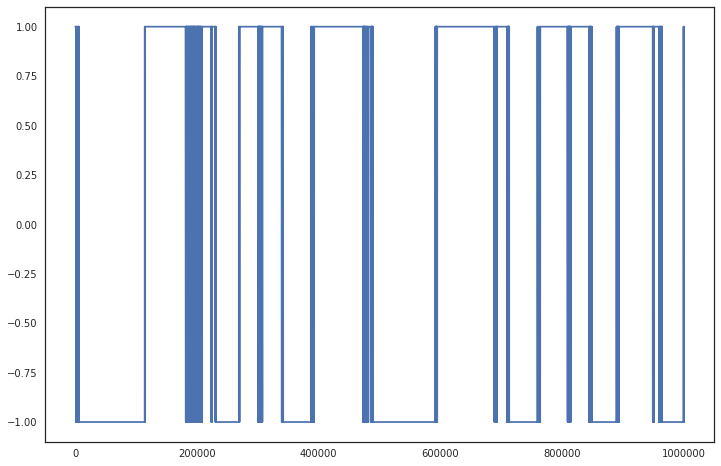

In [57]:
plt.plot(df_offline_ops.)

In [56]:
df_offline_ops.P_TOEXTRACTBOOL

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        1
16        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
24        1
25        1
26        1
27        1
28        1
29        1
         ..
999970   -1
999971   -1
999972   -1
999973   -1
999974   -1
999975   -1
999976   -1
999977   -1
999978   -1
999979   -1
999980   -1
999981   -1
999982   -1
999983   -1
999984   -1
999985   -1
999986   -1
999987   -1
999988   -1
999989   -1
999990   -1
999991   -1
999992   -1
999993   -1
999994   -1
999995   -1
999996   -1
999997   -1
999998   -1
999999   -1
Name: P_TOEXTRACTBOOL, Length: 1000000, dtype: int64

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


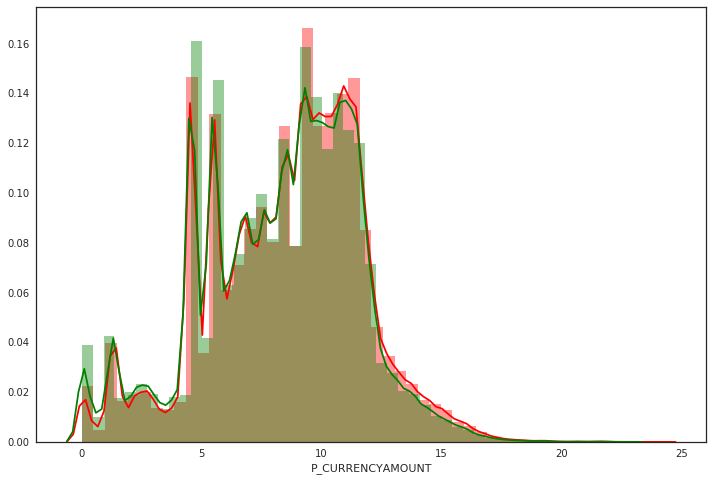

In [52]:
sns.distplot(df_offline_ops.P_BASEAMOUNT.map(np.log1p), color='r')

In [42]:
df_offline_ops.P_BANKOPERATIONID.map(len).value_counts()

12    651654
11    258512
30     86788
15      2480
10       565
8          1
Name: P_BANKOPERATIONID, dtype: int64

In [44]:
df_offline_ops.P_BANKOPERATIONID[df_offline_ops.P_BANKOPERATIONID.map(len) == 30]

0         013520170101133338000080010300
1         013820170101133336000290106300
2         013320170101133423000220010304
3         014520170101133408000440119802
4         014820170101133408000190010300
5         014820170101133431000250010300
6         012620170101133515000010072104
7         012620170101133509000140065404
8         012020170101134320000010076200
9         012020170101134327000020076200
10        011320170101135354000080259404
11        011320170101135340000040259404
12        014820170101140222000010102900
13        011320170101140224000020102904
14        014420170101140931000060275701
15        014420170101140936000080275701
16        010520170101131507000010056200
17        013720170101131557000040056200
18        010620170101132425000030125100
19        010620170101132444000150022800
20        019420170101132514000020028303
21        019420170101132517000030028303
22        010120170101132913000010271201
23        010120170101132916000020271201
24        010920

In [27]:
df_offline_members = pd.read_sql_query("select * from {scheme}.{table_name} where ROWNUM <= 1000000"\
                                   .format(scheme=oracle_scheme, table_name=table_names['off_members']),
                                  con=oracle_connection)

In [6]:
df_offline_members

,ID,P_OPERATIONID,P_CLIENTID,P_BSCLIENTID,P_BANK_CLIENT,P_REGOPENDATE,P_COUNTRYCODE,P_CLIENT_TYPE,P_CLIENTROLE,P_CLIENTKIND,...,P_IPDL,P_DATE_INSERT,P_DATE_UPDATE,P_USERNAME,CHANGEDATE,P_SDP,P_ORGFORM,P_BANKCITY,P_OPER_DATE,P_OPERATIONDATE
0,529719568,529719567,950240000112,6955,2,NaT,KZ,3,1,55,...,1,2017-01-06 09:12:09,None,LOADER,2017-01-06 09:12:09,None,None,АЛМАТЫ,2017-01-04 07:14:20,2017-01-04
1,529719569,529719567,950240000112,88,2,2003-09-02,KZ,1,2,55,...,1,2017-01-06 09:12:09,None,LOADER,2017-01-06 09:12:09,None,28,АЛМАТЫ,2017-01-04 07:14:20,2017-01-04
2,529722751,529722750,950240000112,88,2,2003-09-02,KZ,1,1,55,...,1,2017-01-06 09:12:36,None,LOADER,2017-01-06 09:12:36,None,28,АЛМАТЫ,2017-01-04 07:17:03,2017-01-04
3,529722752,529722750,950240000112,88,2,2003-09-02,KZ,1,2,55,...,1,2017-01-06 09:12:36,None,LOADER,2017-01-06 09:12:36,None,28,АЛМАТЫ,2017-01-04 07:17:03,2017-01-04
4,529722754,529722753,950240000112,6955,2,NaT,KZ,3,1,55,...,1,2017-01-06 09:12:36,None,LOADER,2017-01-06 09:12:36,None,None,АЛМАТЫ,2017-01-04 07:19:40,2017-01-04
5,529722755,529722753,950240000112,6955,2,NaT,KZ,3,2,55,...,1,2017-01-06 09:12:36,None,LOADER,2017-01-06 09:12:36,None,None,АЛМАТЫ,2017-01-04 07:19:40,2017-01-04
6,529722757,529722756,950240000112,6955,2,NaT,KZ,3,1,55,...,1,2017-01-06 09:12:37,None,LOADER,2017-01-06 09:12:37,None,None,АЛМАТЫ,2017-01-04 07:15:11,2017-01-04
7,529722758,529722756,950240000112,88,2,2003-09-02,KZ,1,2,55,...,1,2017-01-06 09:12:37,None,LOADER,2017-01-06 09:12:37,None,28,АЛМАТЫ,2017-01-04 07:15:11,2017-01-04
8,529722760,529722759,160440007161,160440007161,1,NaT,KZ,1,1,55,...,1,2017-01-06 09:12:37,None,LOADER,2017-01-06 09:12:37,None,20,АСТАНА,2017-01-04 07:47:37,2017-01-04
9,529722761,529722759,950240000112,6955,2,NaT,KZ,3,2,55,...,1,2017-01-06 09:12:37,None,LOADER,2017-01-06 09:12:37,None,None,АЛМАТЫ,2017-01-04 07:47:37,2017-01-04


In [23]:
df_offline_members.columns

Index(['ID', 'P_OPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_BANK_CLIENT',
       'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE', 'P_CLIENTROLE',
       'P_CLIENTKIND', 'P_ACCOUNT', 'P_BSACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_DATE_INSERT',
       'P_DATE_UPDATE', 'P_USERNAME', 'CHANGEDATE', 'P_SDP', 'P_ORGFORM',
       'P_BANKCITY', 'P_OPER_DATE', 'P_OPERATIONDATE'],
      dtype='object')

In [37]:
df_categorical_variables_stat(df_offline_members)

next_column: ID
# of uniqs: 1000000
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_OPERATIONID
# of uniqs: 729335
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_CLIENTID
# of uniqs: 200153
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BSCLIENTID
# of uniqs: 217145

NaN    1000000
Name: P_DATE_UPDATE, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_USERNAME
# of uniqs: 1
Viable Categorical. Value counts:
LOADER    1000000
Name: P_USERNAME, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: CHANGEDATE
# of uniqs: 17579
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_SDP
# of

In [17]:
df_offline_members.P_BANK_CLIENT.value_counts()

2    89701
1    10299
Name: P_BANK_CLIENT, dtype: int64

In [8]:
df_susp_members = pd.read_sql_query("select * from {scheme}.{table_name}"\
                                   .format(scheme=oracle_scheme, table_name=table_names['susp_mem']),
                                  con=oracle_connection)

In [9]:
df_susp_members.columns

Index(['ID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_MEMBERURNAME', 'P_MEMBERTYPE',
       'P_BANK_CLIENT', 'P_MEMBERRESCOUNTRYCODE', 'P_MEMBERTAXCODE',
       'P_MEMBEROKED', 'P_MEMBEROKPO', 'P_MEMBERMAINCODE', 'P_MEMBERPHONE',
       'P_MEMBEREMAIL', 'P_MEMBERFOREIGNEXTRA', 'P_MEMBERURFIRSTHEADNAME',
       'P_MEMBERACBIRTHDATE', 'P_MEMBERACBIRTHPLACE', 'P_MEMBERACDOCTYPECODE',
       'P_MEMBERACDOCSERIES', 'P_MEMBERACDOCNUMBER', 'P_MEMBERACDOCWHOM',
       'P_MEMBERACDOCISSUEDATE', 'P_MEMBERREGFULLADDRESS',
       'P_MEMBERREGCOUNTRYCODE', 'P_MEMBERREGAREA', 'P_MEMBERREGREGION',
       'P_MEMBERREGCITY', 'P_MEMBERREGSTREET', 'P_MEMBERREGHOUSE',
       'P_MEMBERREGOFFICE', 'P_MEMBERREGPOSTCODE', 'P_MEMBERSEATFULLADDRESS',
       'P_MEMBERSEATCOUNTRYCODE', 'P_MEMBERSEATAREA', 'P_MEMBERSEATREGION',
       'P_MEMBERSEATCITY', 'P_MEMBERSEATSTREET', 'P_MEMBERSEATHOUSE',
       'P_MEMBERSEATOFFICE', 'P_MEMBERSEATPOSTCODE', 'P_BRANCH', 'P_E_SECTOR',
       'P_EMP_COUNT', 'P_EMP_BANK', 'P_SUSPICIOU

In [10]:
df_categorical_variables_stat(df_susp_members)

next_column: ID
# of uniqs: 1864282
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_CLIENTID
# of uniqs: 1737929
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BSCLIENTID
# of uniqs: 1761161
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERURNAME
# of uniqs: 1
V

# of uniqs: 1608778
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERACDOCWHOM
# of uniqs: 110734
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERACDOCISSUEDATE
# of uniqs: 8849
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERREGFULLADDRESS
# of uniqs

# of uniqs: 1
Viable Categorical. Value counts:
NaN    1864282
Name: P_MEMBERSEATSTREET, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERSEATHOUSE
# of uniqs: 1
Viable Categorical. Value counts:
NaN    1864282
Name: P_MEMBERSEATHOUSE, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_MEMBERSEATOFFICE
# of uniqs: 1
Viable Categorical. Value counts:
NaN    1864282
Name: P_MEMBERSEATOFFICE, dtype: int64
--------------------------------------------------------------------------------
---------------------------------------------------------------

# of uniqs: 72317
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_DATE_UPDATE
# of uniqs: 27911
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_USERNAME
# of uniqs: 3
Viable Categorical. Value counts:
AML_USER    1766664
LOADER        97617
NaN               1
Name: P_USERNAME, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------------------------------------

NaN             1845869
 750000000.0       4886
 710000000.0       2506
 510000000.0       1440
 390000000.0       1179
 630000000.0       1068
 550000000.0        971
 350000000.0        868
 470000000.0        862
 150000000.0        808
 310000000.0        808
 190000000.0        771
 230000000.0        736
 590000000.0        515
 270000000.0        466
 110000000.0        268
 430000000.0        261
Name: SEAT_AREA_KATO_ID, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: REG_REGION_KATO_ID
# of uniqs: 177
Viable Categorical. Value counts:
NaN             1845930
 711110000.0       1251
 751410000.0       1233
 751110000.0       1023
 511000000.0        925
 751710000.0        910
 751310000.0        781
 151000000.0        728
 471000000.0        701
 231000000.0

# of uniqs: 5326
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: BL_PERCENT
# of uniqs: 46
Viable Categorical. Value counts:
0.00      1856944
100.00       3000
90.00        1593
94.00         477
92.00         441
91.66         401
90.66         360
93.00         264
91.00         225
94.50         122
94.66          81
93.33          72
95.00          48
92.66          30
95.50          30
91.75          24
95.33          22
96.00          20
92.33          15
91.60          14
91.50          12
92.50          11
96.50           9
96.66           7
91.33           6
90.75           6
90.33           5
93.50           4
93.40           4
98.00           4
93.75           4
97.66           4
97.00           3
94.40           3
97.50           3
92.

In [11]:
df_susp_accounts = pd.read_sql_query("select * from {scheme}.{table_name}"\
                                   .format(scheme=oracle_scheme, table_name=table_names['susp_acc']),
                                  con=oracle_connection)

In [12]:
df_susp_accounts.columns

Index(['ID', 'P_SUSPICIOUSOPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_NAME',
       'P_BANK_CLIENT', 'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE',
       'P_CLIENTROLE', 'P_CLIENTKIND', 'P_ACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_DATE_INSERT',
       'P_DATE_UPDATE', 'P_USERNAME', 'P_HISTORY', 'CHANGEDATE', 'P_BSACCOUNT',
       'P_LASTNAME', 'P_FIRSTNAME', 'P_MIDDLENAME', 'P_SDP', 'P_ORGFORM',
       'P_CLIENT_CARD_ID', 'P_BANKCITY', 'P_OFFSHORE_CODE', 'P_MEMBERCOMMENTS',
       'CLIENT_CARD_ID', 'CLIENT_CARD_VERSION', 'IS_BANK_OFFSHORE'],
      dtype='object')

In [13]:
df_categorical_variables_stat(df_susp_accounts)

next_column: ID
# of uniqs: 913563
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_SUSPICIOUSOPERATIONID
# of uniqs: 401504
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_CLIENTID
# of uniqs: 165599
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BSCLIENTID
# of uniq

# of uniqs: 66
Viable Categorical. Value counts:
NaN       832966
2209       16139
1001       14203
1002       11514
2203       11294
2204        8949
2207        4217
2860        2672
1860        2191
1005        2159
2206        1829
2870        1179
1003        1155
1870         566
1052         535
2215         460
1417         321
1424         312
1411         266
1740          94
2013          53
2217          52
2202          49
2205          46
7250          36
7999          35
1428          30
1741          29
1051          26
1256          25
           ...  
4900           7
1879           6
2721           6
5921           5
6075           5
2240           5
6575           5
6126           3
1854           3
1431           3
4607           3
2223           3
2851           3
1856           2
2211           2
4465           2
6126_1         2
5608           2
2054           2
1867           1
1602           1
2213           1
1492           1
2125           1
1654           1

In [14]:
df_susp_ops = pd.read_sql_query("select * from {scheme}.{table_name}"\
                                   .format(scheme=oracle_scheme, table_name=table_names['susp_operations']),
                                  con=oracle_connection)

In [15]:
df_susp_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_ORDERNUMBER', 'P_BRANCH',
       'P_CURRENCYCODE', 'P_OPERATIONDATETIME', 'P_BASEAMOUNT',
       'P_CURRENCYAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCDATE',
       'P_DOCCATEGORY', 'P_OPERATIONSTATUS', 'P_OPERATIONREASON',
       'P_MESS_NUMBER', 'P_MESS_DATE', 'P_MESS_KIND', 'P_MESS_STATUS',
       'P_SUSPIC_KIND', 'P_SUSPICIOUSTYPECODE', 'P_CRITERIAFIRST',
       'P_CRITERIASECOND', 'P_CRITERIATHIRD', 'P_CRITERIADIFFICULTIES',
       'P_OPERATIONEXTRAINFO', 'P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL',
       'P_DATE_INSERT', 'P_DATE_UPDATE', 'P_USERNAME', 'P_OPERATION_LIST',
       'P_COMMENT', 'P_APPROVE', 'P_ATTACHMENT_COMMENT', 'P_HISTORY',
       'CHANGEDATE', 'P_DOCTYPE', 'P_DOCSUSPIC', 'P_PROPERTY',
       'P_PROPERTYNUMBER', 'P_ORIG_OPER_REASON', 'P_DETECTED_BY_FILIAL',
       'P_USER_DETECTED', 'P_COUNTER_MEASURE', 'P_OPERATION_CNT',
       'P_OPERATION_CNT_M'],
      dtype='object')

In [16]:
df_categorical_variables_stat(df_susp_ops)

next_column: ID
# of uniqs: 401557
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_ISSUEDBID
# of uniqs: 6
Viable Categorical. Value counts:
 3.0    178873
 5.0     96883
 4.0     53634
 1.0     50176
 2.0     21969
NaN         22
Name: P_ISSUEDBID, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BANKOPERATIONID
# of uniqs: 398551
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----

# of uniqs: 4
Viable Categorical. Value counts:
 1.0    401514
NaN         22
 4.0        11
 3.0        10
Name: P_MESS_STATUS, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_SUSPIC_KIND
# of uniqs: 7
Viable Categorical. Value counts:
1    221645
4     81140
3     56193
6     31452
2      7368
7      3620
0       139
Name: P_SUSPIC_KIND, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_SUSPICIOUSTYPECODE
# of uniqs: 24
Viable Categorical. Value counts:
 1671.0    257771
 511.0      71808
 2011.0     29660
 521.0      15788
 530.0       6850
 911

NaN    401557
Name: P_DOCSUSPIC, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_PROPERTY
# of uniqs: 4
Viable Categorical. Value counts:
NaN    401514
4          35
1           6
2           2
Name: P_PROPERTY, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_PROPERTYNUMBER
# of uniqs: 12
Viable Categorical. Value counts:
NaN                             401514
Предоставим по запросу              29
Предоставим по запросу               3
Указаны в пункте 3.14                2
03-044-307-043                       2
Номера указаны в пункте 3.14     

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


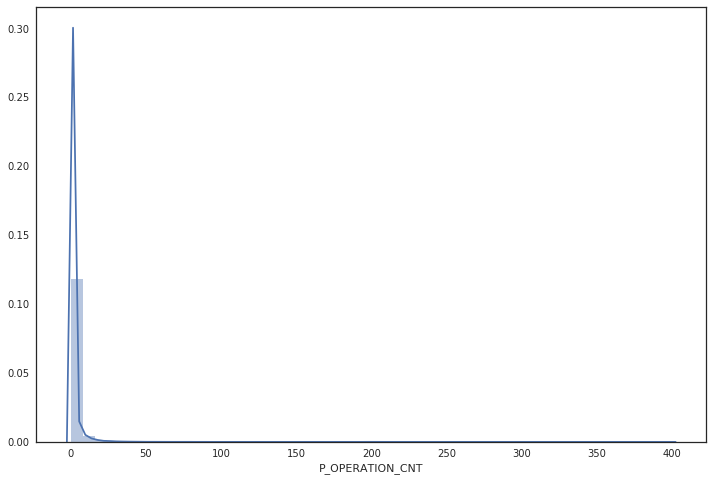

In [25]:
sns.distplot(df_susp_ops.P_OPERATION_CNT[~df_susp_ops.P_OPERATION_CNT.isnull()])

In [17]:
import re

In [20]:
s = '|529274688||529316886|'

In [21]:
re.findall('\d+', s)

['529274688', '529316886']

In [29]:
operationlist_notnull = df_susp_ops.P_OPERATION_LIST[~df_susp_ops.P_OPERATION_LIST.isnull()]

In [30]:
operationlist_counts = operationlist_notnull.map(lambda s: len(re.findall('\d+', s)))

In [34]:
operationlist_counts[:10], df_susp_ops.P_OPERATION_CNT_M[~df_susp_ops.P_OPERATION_LIST.isnull()][:10]

(0    2
 1    3
 2    2
 3    2
 4    2
 5    9
 6    4
 7    6
 8    2
 9    2
 Name: P_OPERATION_LIST, dtype: int64, 0    1
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 7    1
 8    1
 9    1
 Name: P_OPERATION_CNT_M, dtype: int64)

In [39]:
df_susp_ops.ID

0         530136354
1         530136365
2         530136375
3         530136384
4         530132542
5         530079203
6         530080686
7         530080699
8         530119844
9         530119873
10        530119891
11        530119899
12        529999668
13        529999677
14        529999685
15        529999694
16        530047390
17        530047421
18        530047440
19        530047479
20        530064975
21        530064986
22        530065655
23        530118477
24        530118491
25        530118926
26        530118946
27        529994082
28        529994091
29        529994100
            ...    
401527    569159747
401528    569159756
401529    569159765
401530    569159774
401531    569160599
401532    569160851
401533    569160860
401534    569159135
401535    569159144
401536    569159153
401537    569160608
401538    569160617
401539    569160626
401540    569160635
401541    569160644
401542    569159162
401543    569159171
401544    569159180
401545    569159999


In [36]:
operationlist_counts.value_counts()

1      301996
2       31417
3       24034
4       10294
5        6029
6        4959
7        3133
8        2412
9        2202
10       1562
11       1322
12       1152
13        918
14        785
15        736
16        599
17        567
18        432
19        421
20        328
21        314
22        244
23        238
24        235
25        222
200       211
26        197
27        174
29        144
28        136
        ...  
149         1
303         1
304         1
317         1
155         1
156         1
306         1
158         1
313         1
160         1
392         1
296         1
123         1
181         1
381         1
197         1
337         1
196         1
195         1
126         1
288         1
127         1
131         1
189         1
187         1
186         1
388         1
134         1
294         1
250         1
Name: P_OPERATION_LIST, Length: 248, dtype: int64

In [35]:
df_susp_ops.ID[:20]

0     530136354
1     530136365
2     530136375
3     530136384
4     530132542
5     530079203
6     530080686
7     530080699
8     530119844
9     530119873
10    530119891
11    530119899
12    529999668
13    529999677
14    529999685
15    529999694
16    530047390
17    530047421
18    530047440
19    530047479
Name: ID, dtype: int64

In [41]:
df_offline_ops[df_offline_ops.ID == 529719568]

,ID,P_ISSUEDBID,P_BANKOPERATIONID,P_ORDERNUMBER,P_BRANCH,P_CURRENCYCODE,P_OPERATIONDATETIME,P_BASEAMOUNT,P_CURRENCYAMOUNT,P_EKNPCODE,...,P_PROPERTYNUMBER,P_KFM_OPER_REASON,P_BS_OPER_TYPE,P_ORIG_OPER_NUMBER,P_HISTORY,P_WAS_SEND,P_SDP,RISK_CHECKED,P_INNER_SUSP_CHECK,P_OPERATIONDATE


In [ ]:
#query = "select * from "+oracle_scheme+".tb_ipdl"
query = "select count(1) from "+oracle_scheme+".TB_OFFLINEOPERATIONS"
for result in oracle_cursor.execute(query):
    print("tb_ipdl has {0} rows".format(result[0]))